# **1. Importación de *modules***

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import scale

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset**

**[!] Importamos el dataset limpio *properatti_tp2.csv* para su análisis**

In [4]:
data = pd.read_csv("./properatti_tp2.csv", sep = ",", low_memory=False) 
data.head(3)
data.shape

sup_total  sup_cubierta  precio_por_m2  habitaciones  am_garage  am_balcon  \
0       55.0          40.0    1127.272727           2.0          0          0   
1       55.0          55.0    1309.090909           2.0          0          0   
2      106.0          78.0    1226.415094           2.0          1          0   

   am_parrilla  am_piscina  am_terraza  am_patio  ...  pn_Villa de Mayo  \
0            0           0           0         1  ...                 0   
1            0           0           0         0  ...                 0   
2            0           0           0         1  ...                 0   

   pn_Villa del Parque  pn_Village Golf & Tennis Country Club  \
0                    0                                      0   
1                    0                                      0   
2                    0                                      0   

   pn_Virasoro Village  pn_Virrey del Pino  pn_Virreyes  pn_Wilde  \
0                    0                   0            0         0   
1                    0                   0            0         0   
2                    0                   0            0         0   

   pn_William Morris  pn_Zelaya  pn_coordenadas 34.255511  
0                  0          0                         0  
1                  0          0                         0  
2                  0          0                         0  

[3 rows x 467 columns]

(41760, 467)

# **3. Tratamiento de los datos**

## **3.1. Análisis de correlación**

<AxesSubplot:>

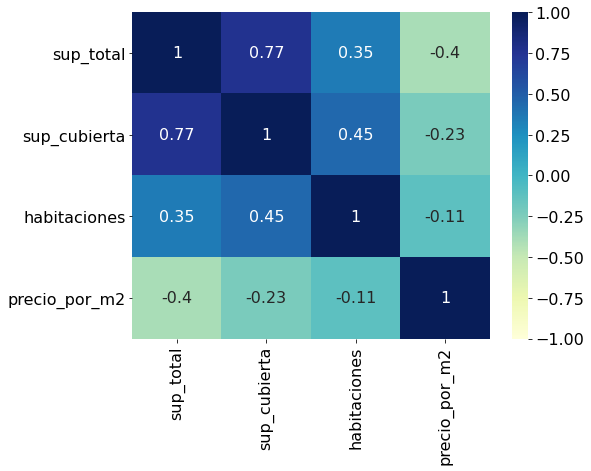

In [5]:
# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
sns.heatmap(data[['sup_total', 'sup_cubierta', 'habitaciones', 'precio_por_m2']].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

## **3.2. Supuestos de Markov**

### *3.2.1. Linearidad del modelo*

In [6]:
#linearidad del modelo
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(features, target):
    X = data[features]
    y = data[target]

    # Tenemos que agregar explícitamente a una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. valores predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuos vs. valores predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')

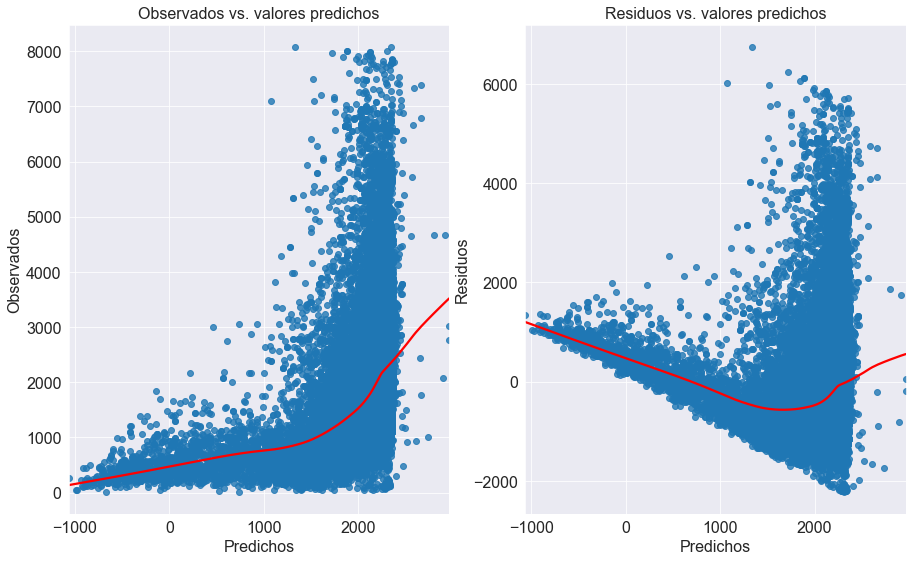

In [7]:
linearity_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])  

### *3.2.2. Media de los errores*

In [8]:
X = data[['sup_total','sup_cubierta','habitaciones']]
y = data["precio_por_m2"]
model = sm.OLS(y, X).fit()
model.resid.mean()

408.6906021537015

### *3.2.3. Valor esperado de los errores*

In [9]:
def residuals_test(features, target):
  X = data[features]
  y = data[target]

  # Tenemos que agregar explícitamente a una constante:
  X = sm.add_constant(X)

  model = sm.OLS(y, X).fit()
  residuals = model.resid

  p = sns.scatterplot(data = data, x = data[features], y = residuals);
  p.axhline(0, color = "green")
  p.set(ylabel = "Residuals");

#### 3.2.3.1. Superficie total

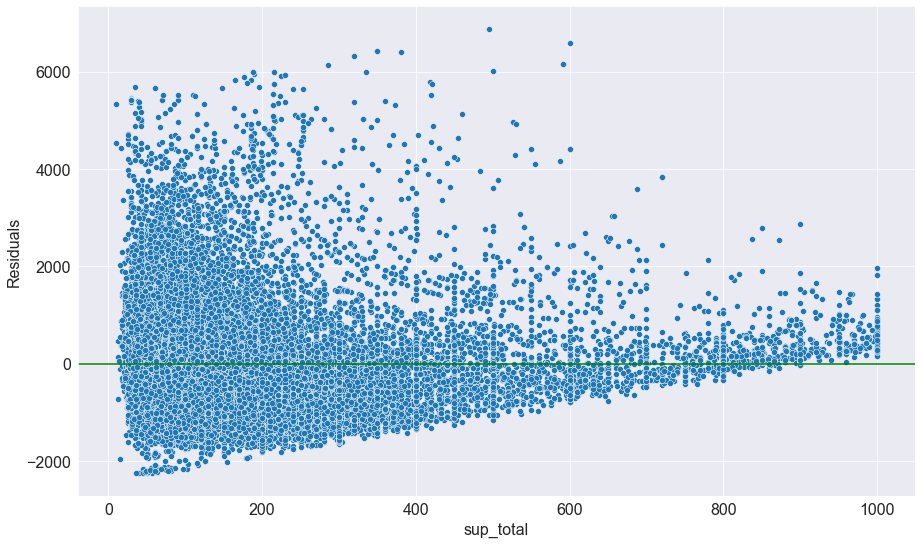

In [10]:
residuals_test('sup_total', "precio_por_m2")

#### 3.2.3.2. Superficie cubierta

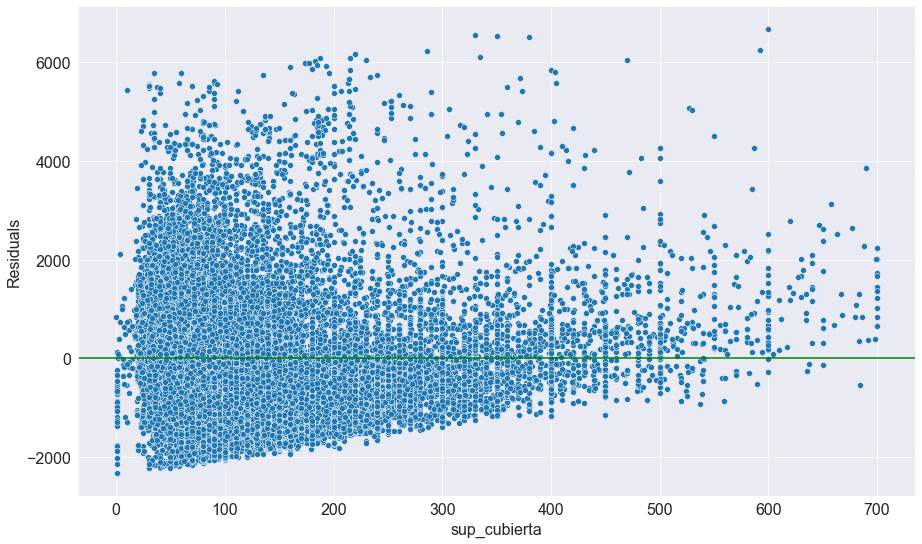

In [11]:
residuals_test('sup_cubierta',"precio_por_m2")

#### 3.2.3.3. Habitaciones

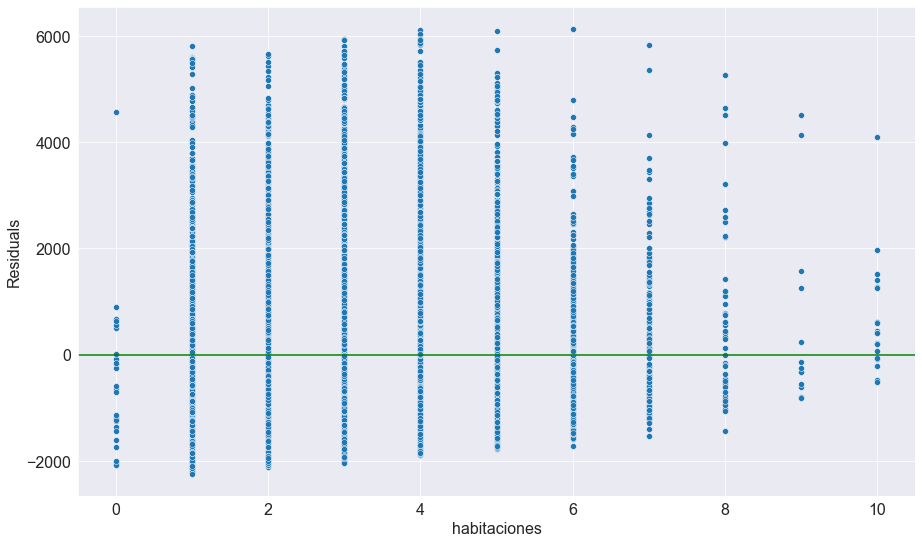

In [12]:
residuals_test("habitaciones", "precio_por_m2")

### *3.2.4. Multicolinearidad*

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def multicolinearidad_test (X):
  X_constant = sm.add_constant(X)
  vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
  return (pd.DataFrame({'vif': vif[1:]}, index=X.columns).T)

In [14]:
multicolinearidad_test(data[['sup_total','sup_cubierta','habitaciones']])

sup_total  sup_cubierta  habitaciones
vif   2.479854       2.70879      1.249485

### *3.2.5. Homocedasticidad*

In [15]:
#homocedasticidad
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)


def homoscedasticity_test(features, target):
    X = data[features]
    y = data[target]
   
    model = sm.OLS(y, X).fit()
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    #Breusch-Pagan Test
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    #Goldfeld-Quandt test
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  8529.725649
p-value                           0.000000
f-value                        3572.803825
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.992474
p-value      0.707385

 Residuals plots ----


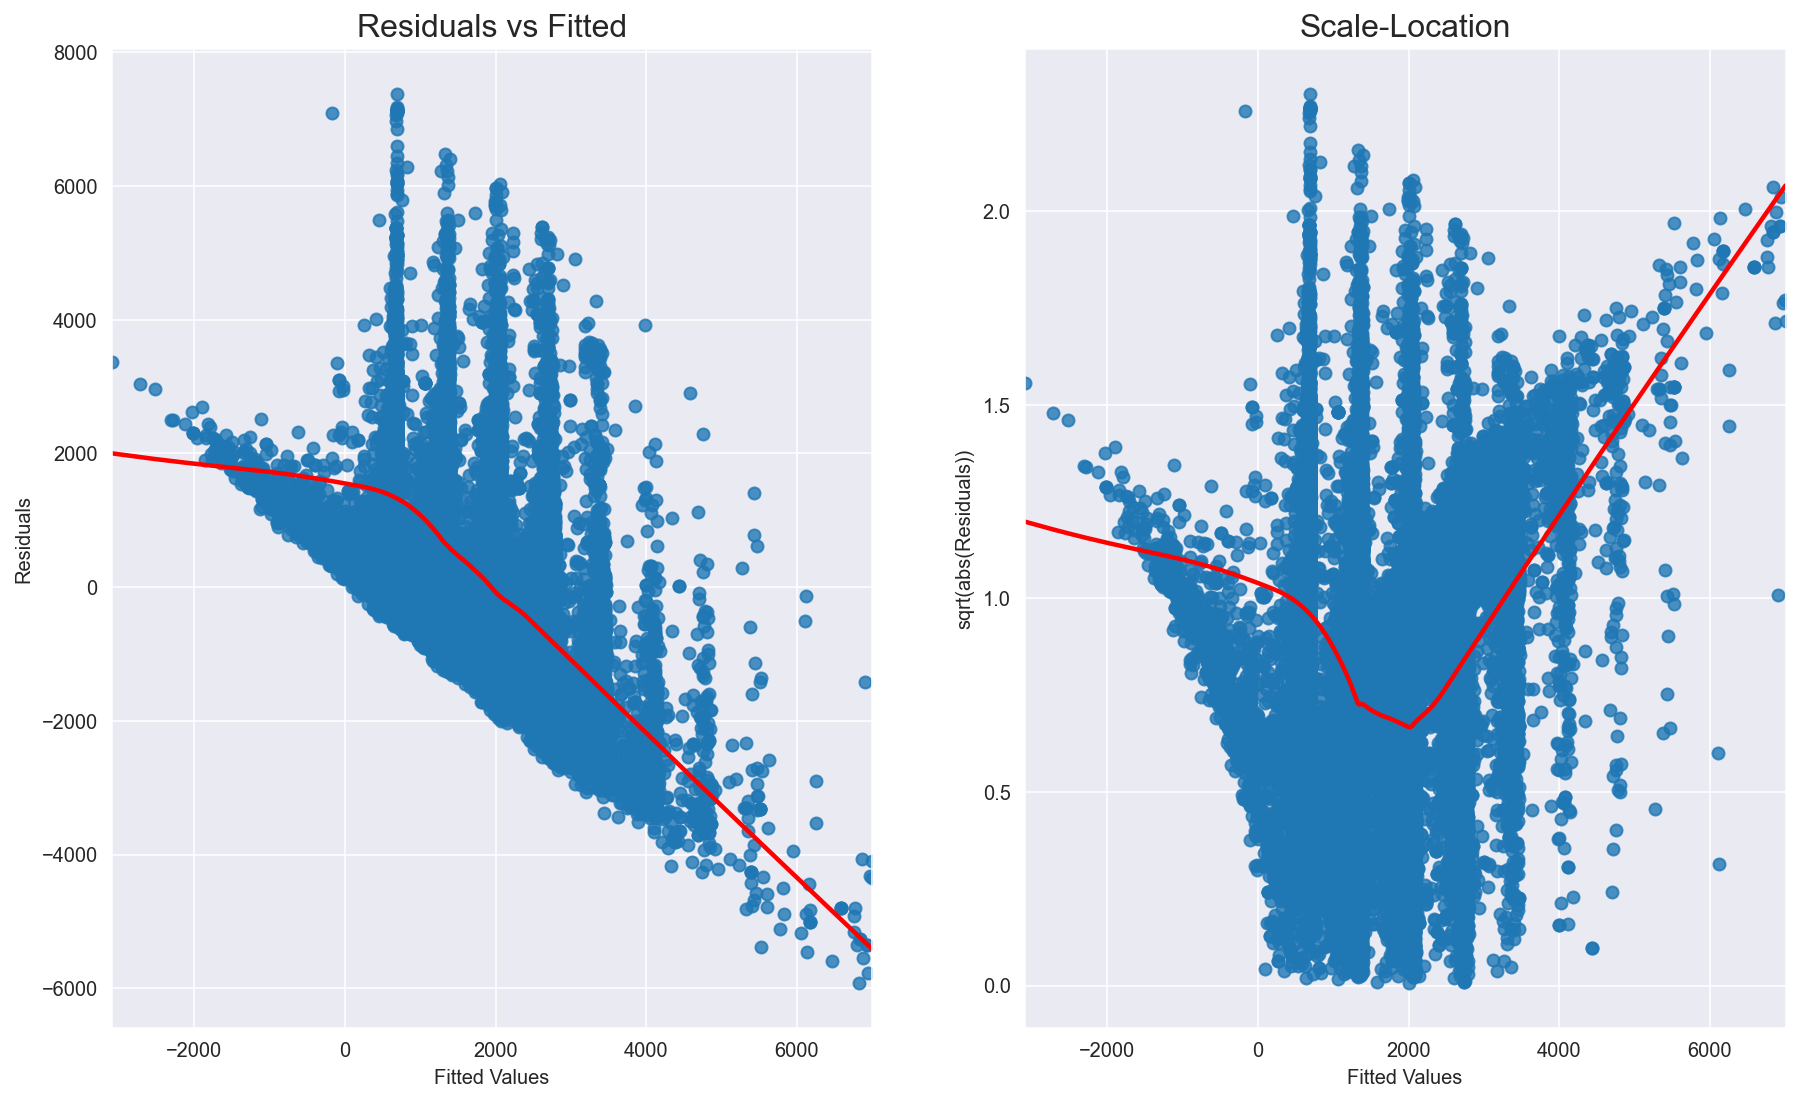

In [16]:
homoscedasticity_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])

### *3.2.6. Autocorrelación*

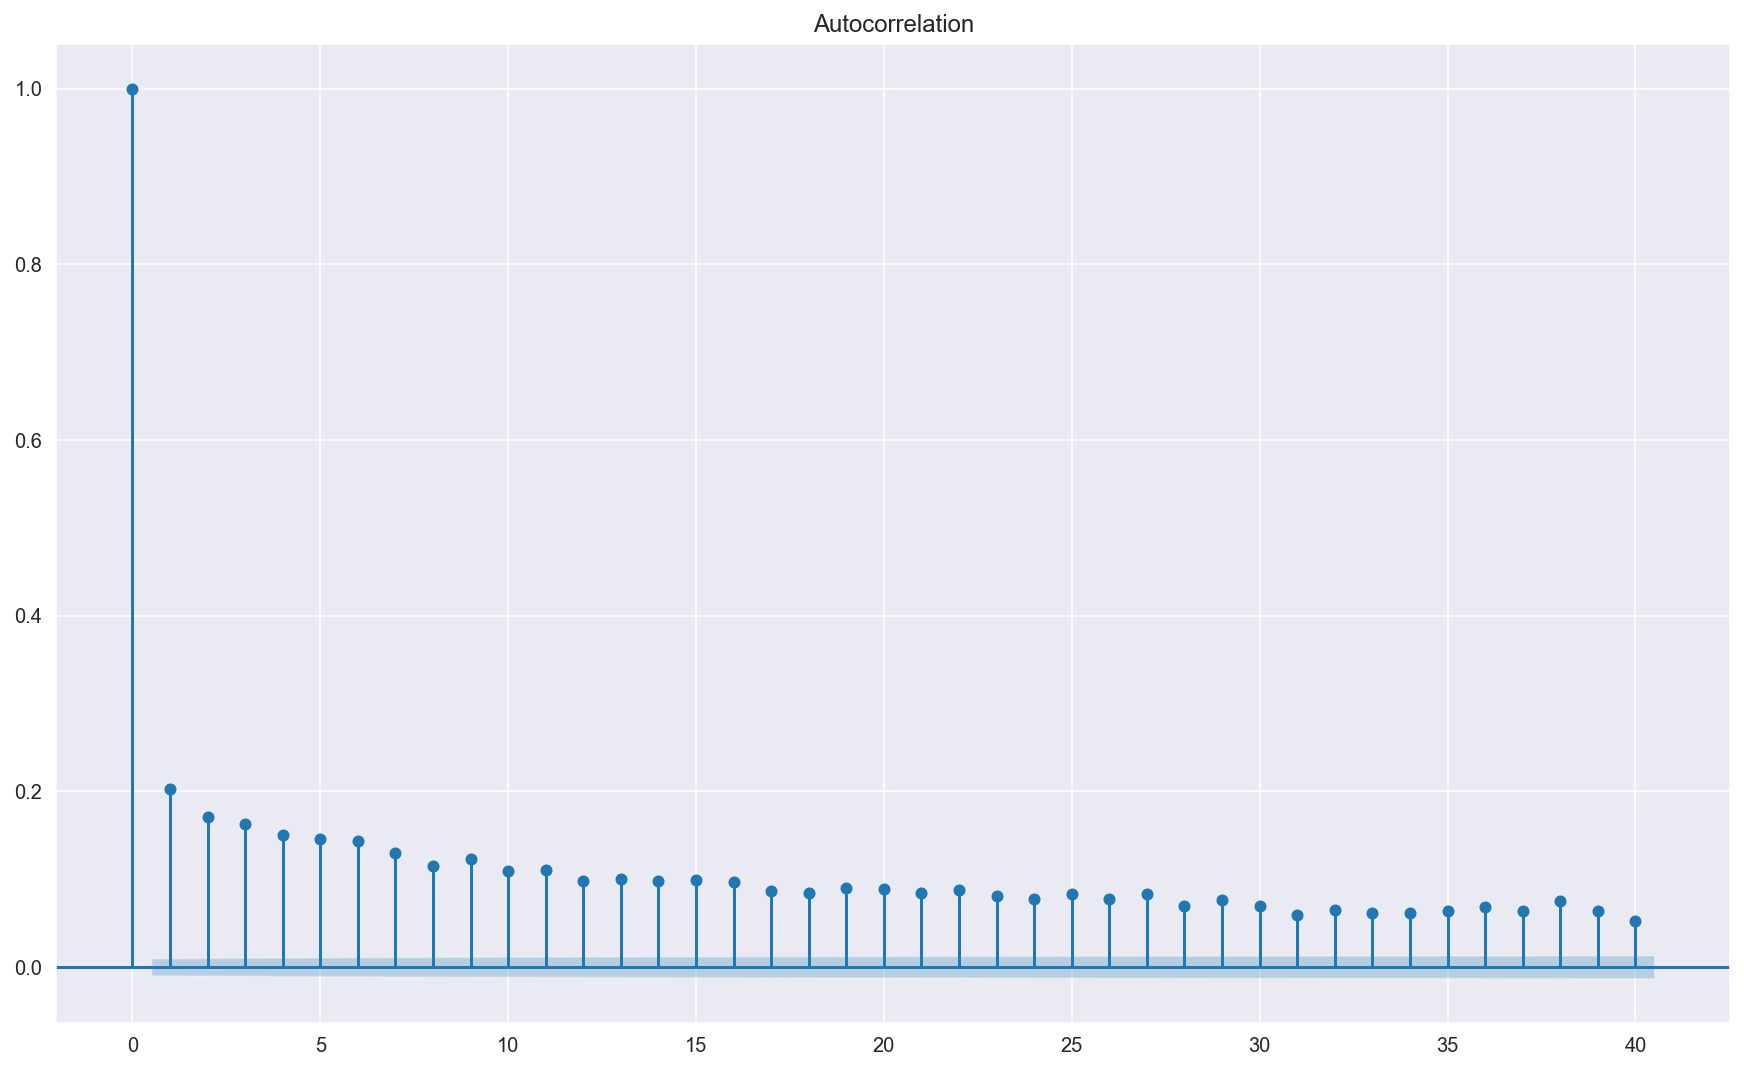

In [17]:
#autocorrelacion
import statsmodels.tsa.api as smt

X = data[['sup_total','sup_cubierta','habitaciones']]
y = data["precio_por_m2"]
model = sm.OLS(y, X).fit()

acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
#acf.show();

### *3.2.7. Normalidad de los residuos*

In [18]:
#normalidad de los residuos
from scipy import stats

def normality_of_residuals_test(features, target):
    X = data[features]
    y = data[target]
    model = sm.OLS(y,X).fit()
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

C:\Users\msaied\Anaconda3\envs\ds\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 2217.9125, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9923, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6274, p-value: 0.0000
Anderson-Darling test ---- statistic: 40.7737, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


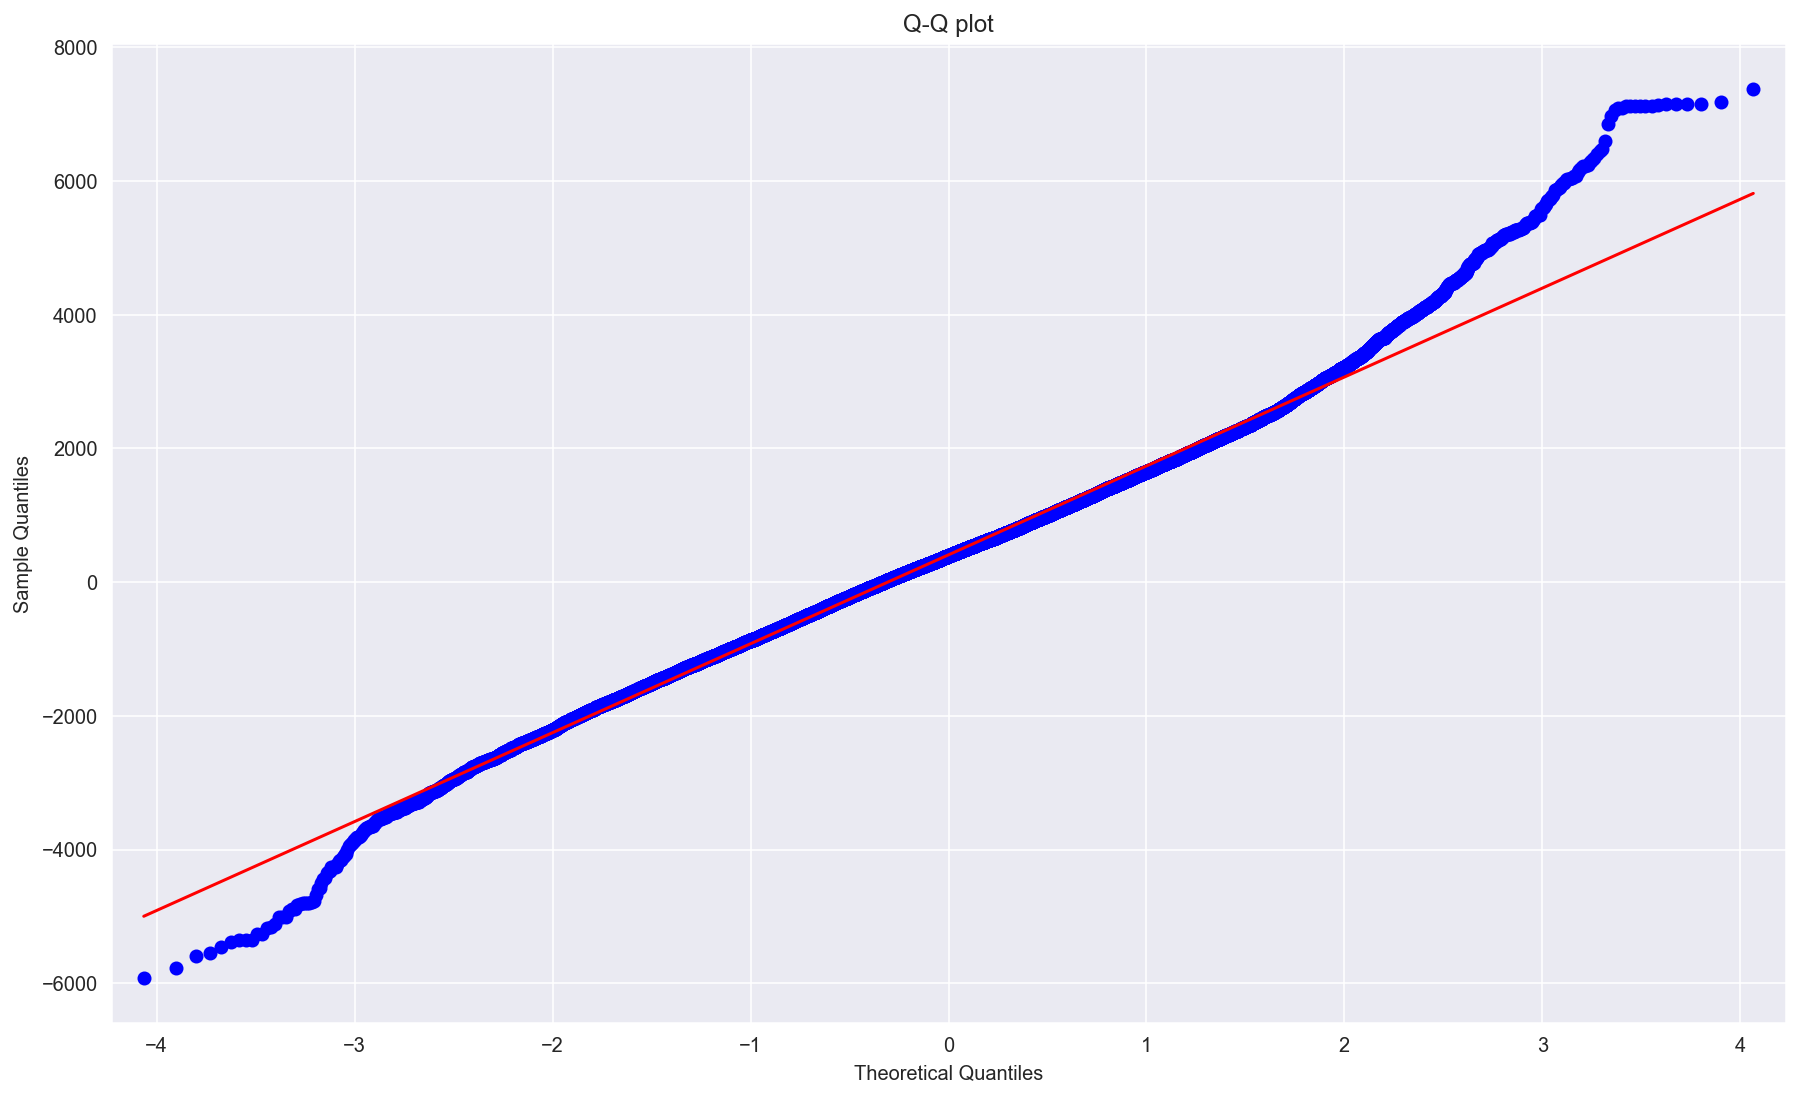

In [19]:
normality_of_residuals_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])

<AxesSubplot:ylabel='Density'>

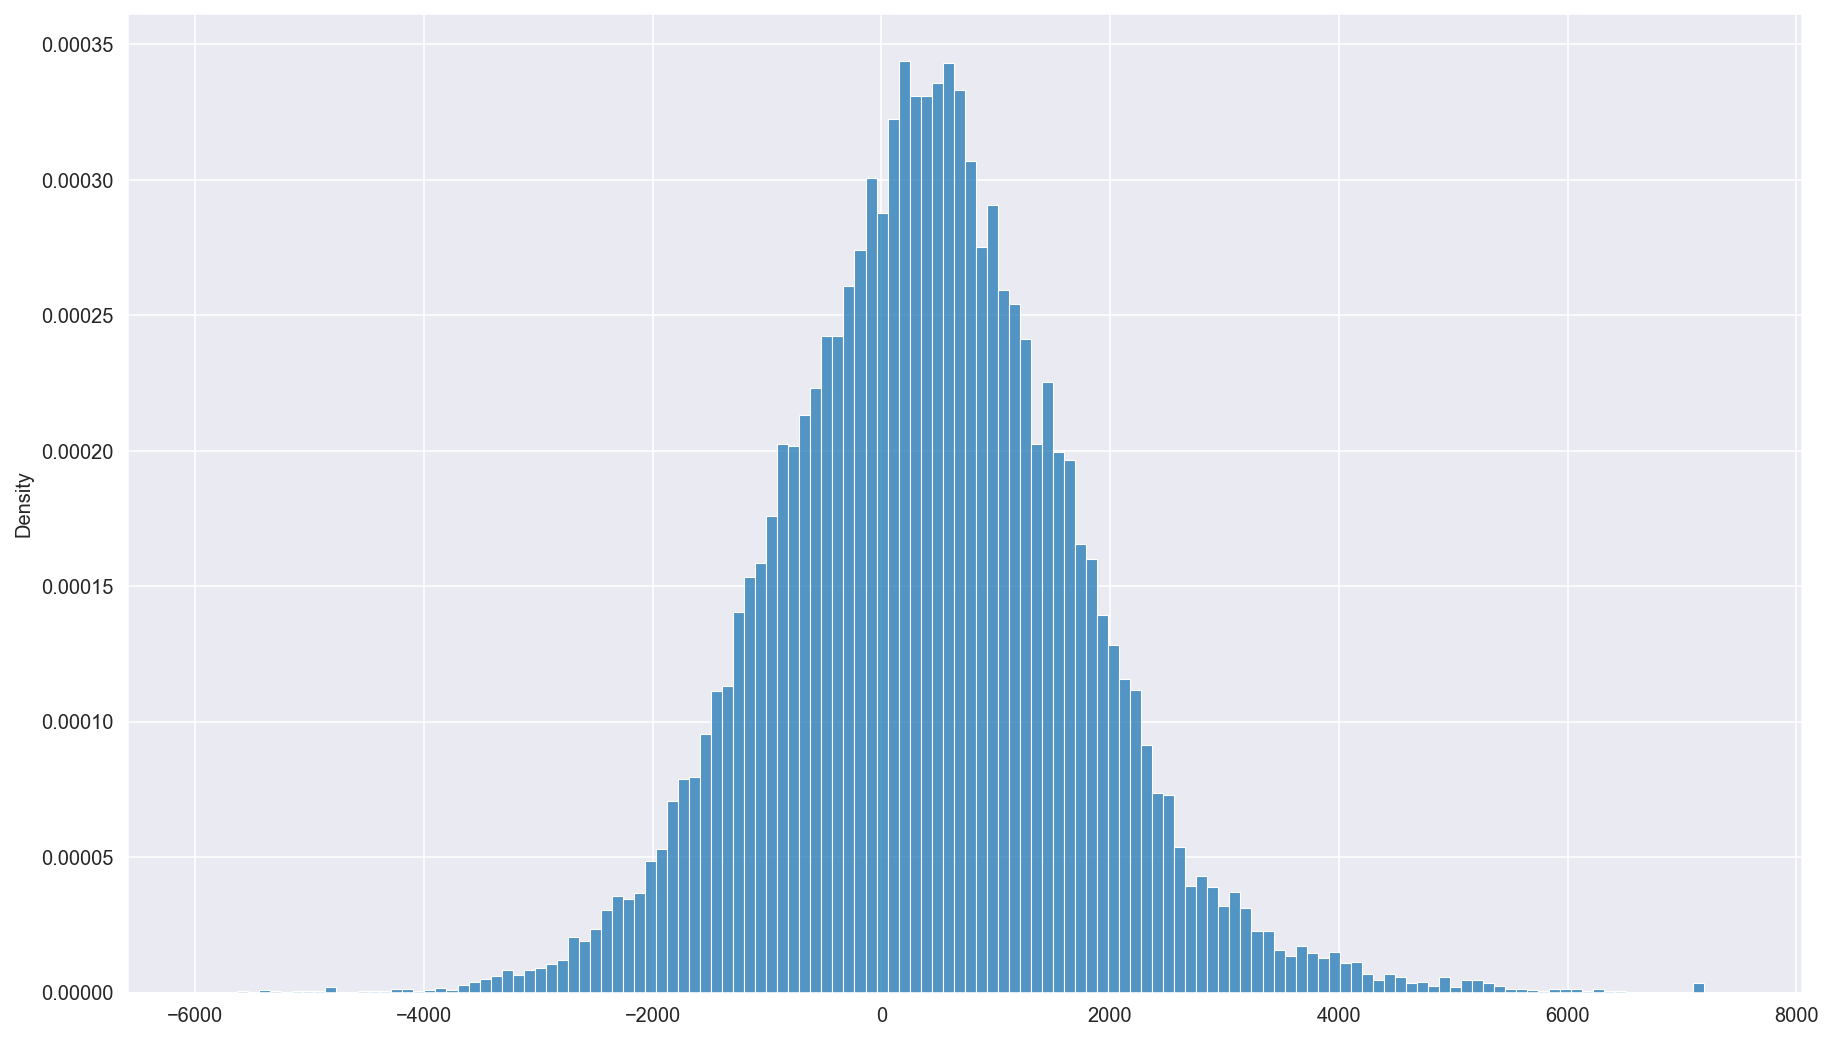

In [20]:
sns.histplot(model.resid, kde = False, stat = 'density', line_kws={'linewidth':5})

## **3.3. Modelado**

### *3.3.1. Regresión lineal simple (RLS)*

#### 3.3.1.1. Definición de la función regresora *rls*

In [21]:
def rls(X, y, columna):
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage    shuffle=False
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1, shuffle = False)
    lr = LinearRegression() # Fiteamos el modelo sobre los vectores X e y.
    lr.fit(Xtrain, ytrain)
    test_sklearn = np.array(Xtest).reshape(-1,1)
    ypred = lr.predict(test_sklearn)
    
    print(f'''
    Coeficiente\t{lr.coef_.round(4)}
    Intercepto\t{lr.intercept_.round(4)}
    MAE\t{mean_absolute_error(ytest, ypred).round(2)}
    MSE\t{mean_squared_error(ytest, ypred).round(2)}
    RMSE\t{np.sqrt(mean_squared_error(ytest, ypred)).round(2)}
    R2\t{r2_score(ytest, ypred).round(2)}
    ''')

    sns.regplot(data = data, x = columna, y = 'precio_por_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})


#### 3.3.1.2. RLS sin normalización

##### Superficie total

*** Superficie total ***

    Coeficiente	[-2.5517]
    Intercepto	2444.435
    MAE	697.94
    MSE	959607.11
    RMSE	979.6
    R2	0.08
    


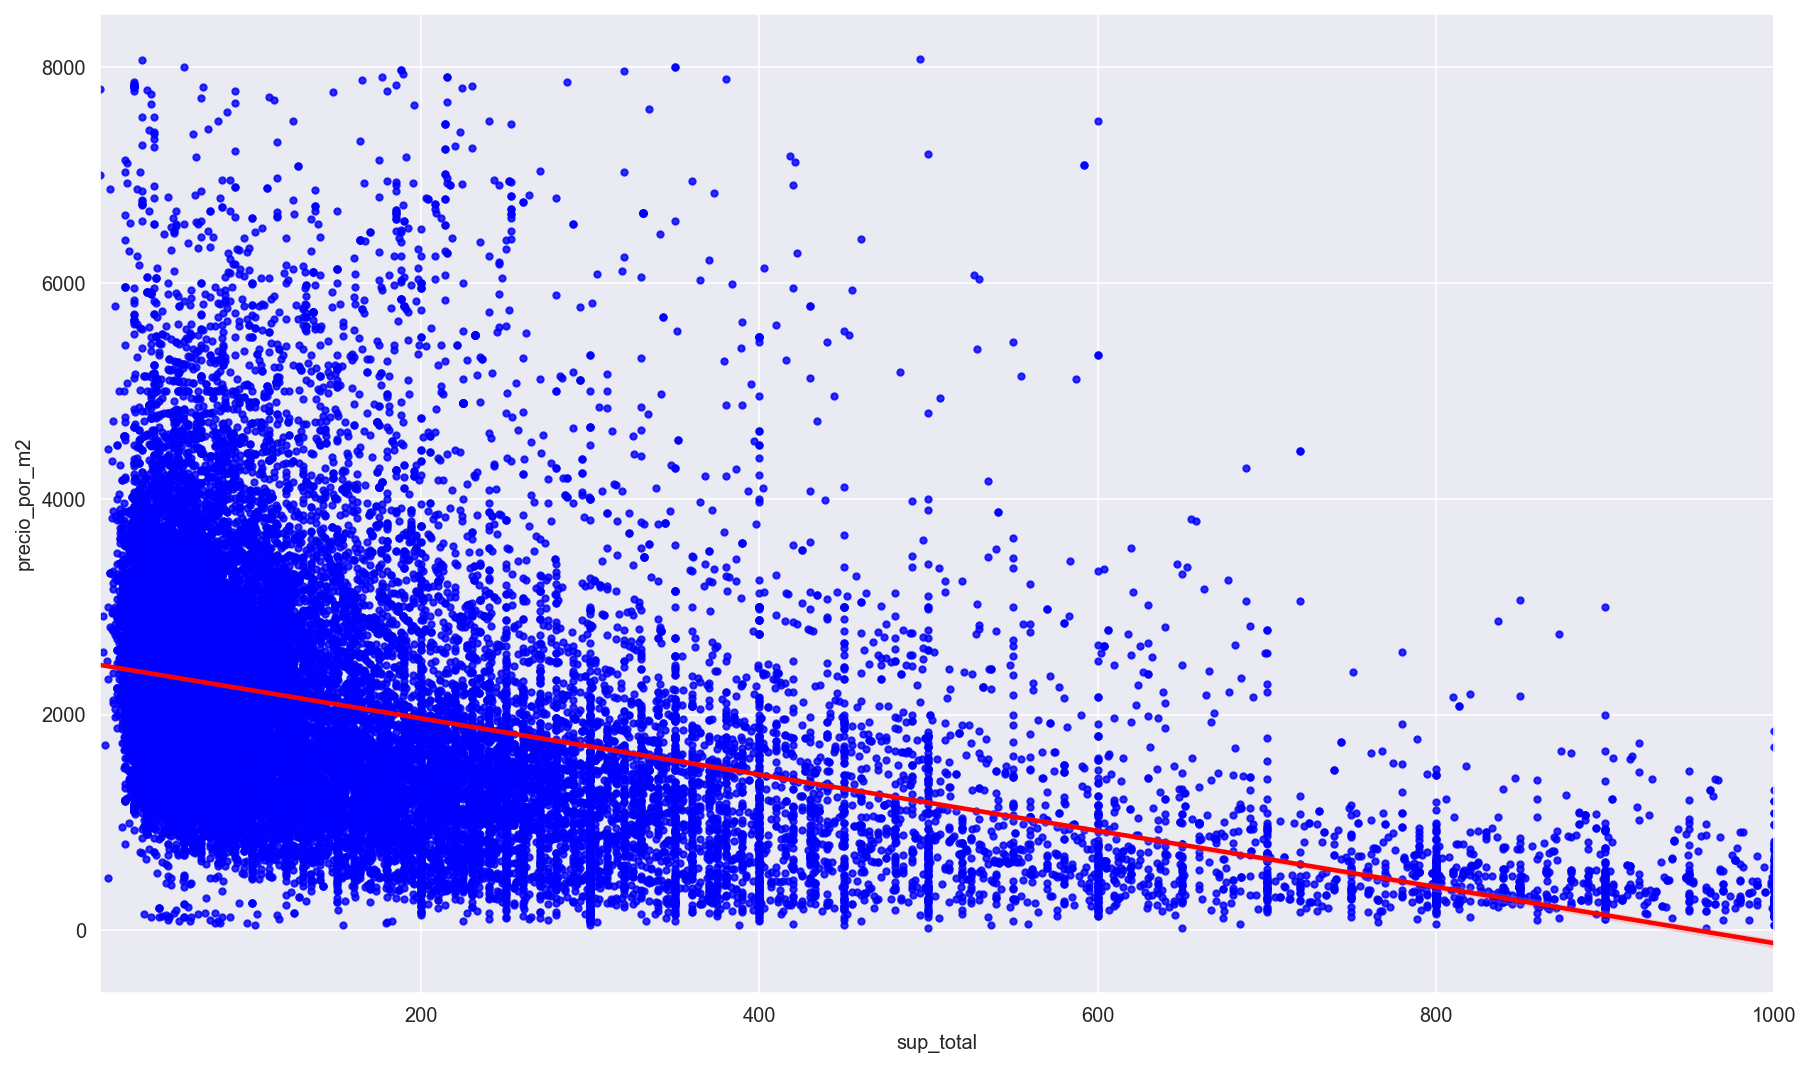

In [22]:
print("*** Superficie total ***")
X = data[['sup_total']]
y = data['precio_por_m2']
rls(X, y, 'sup_total')

##### Superficie cubierta

*** Superficie cubierta ***

    Coeficiente	[-2.599]
    Intercepto	2329.6848
    MAE	724.28
    MSE	1034446.39
    RMSE	1017.08
    R2	0.01
    


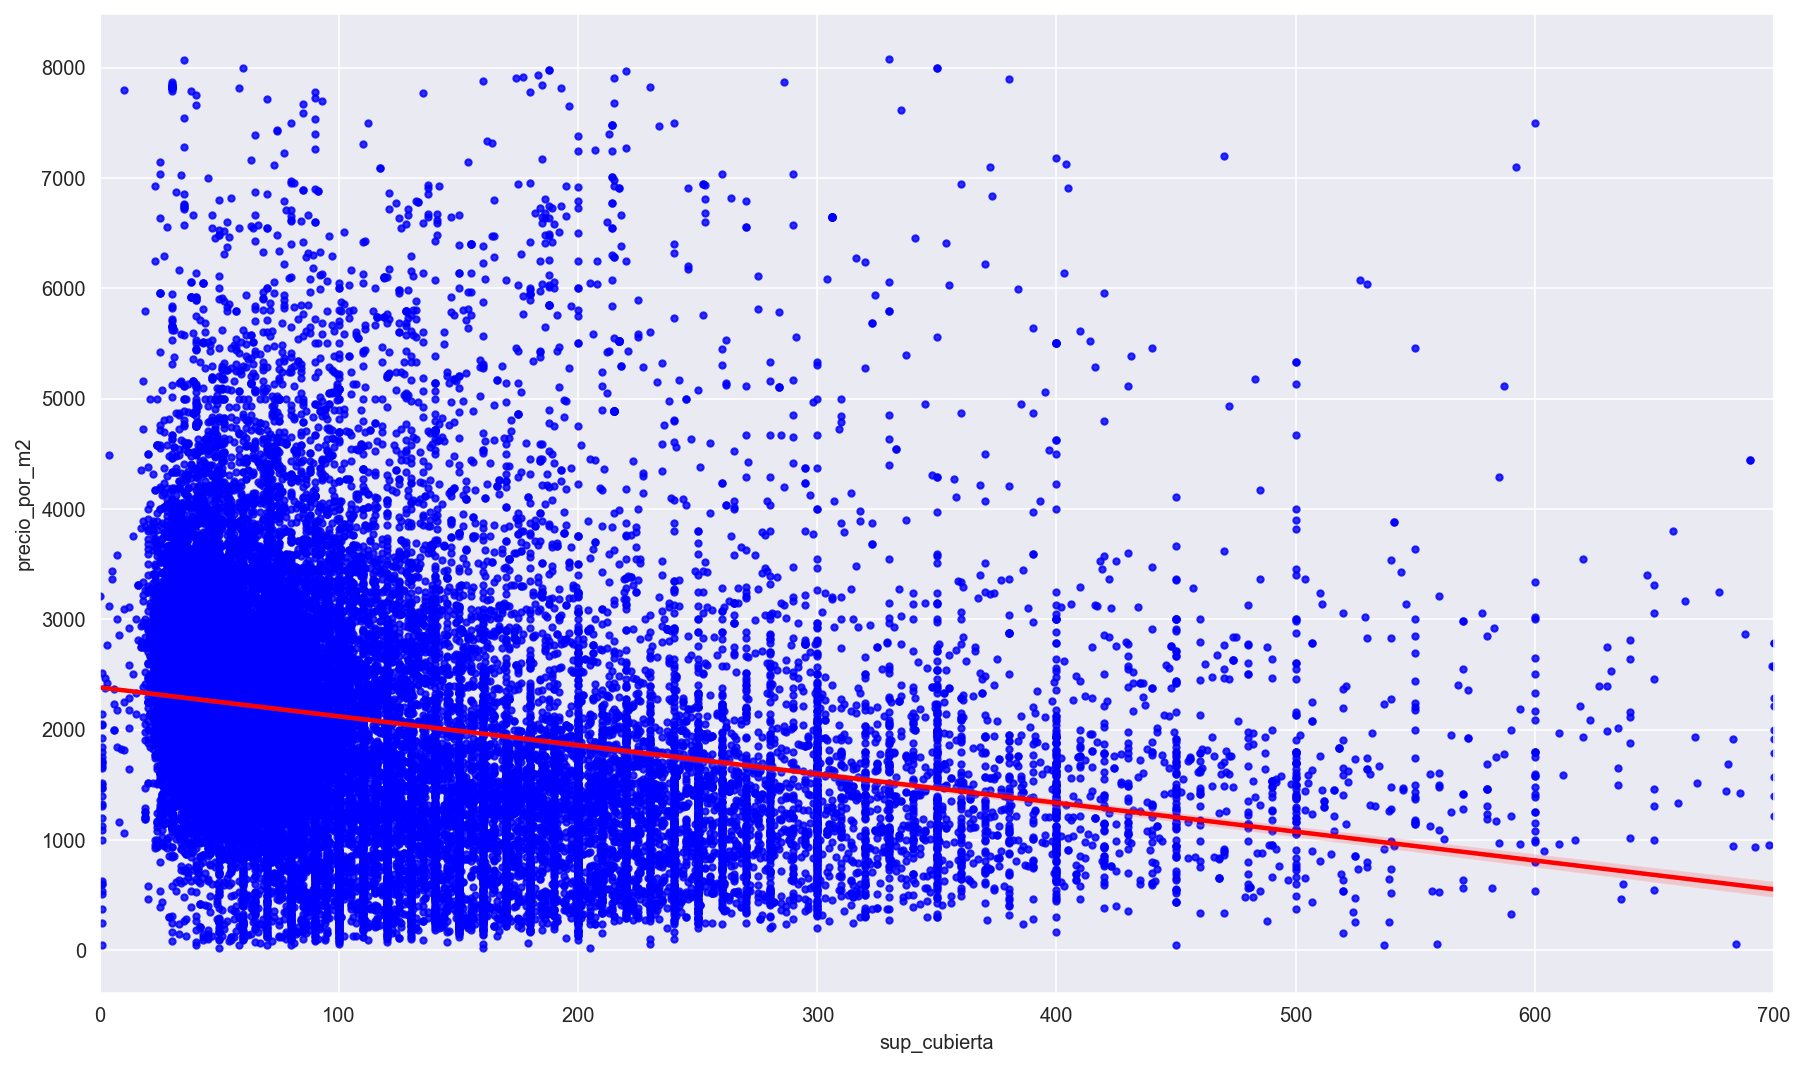

In [23]:
print("*** Superficie cubierta ***")
X = data[['sup_cubierta']]
y = data['precio_por_m2']
rls(X, y, 'sup_cubierta')

##### Habitaciones

*** Habitaciones ***

    Coeficiente	[-108.4166]
    Intercepto	2329.3643
    MAE	759.86
    MSE	1096150.33
    RMSE	1046.97
    R2	-0.05
    


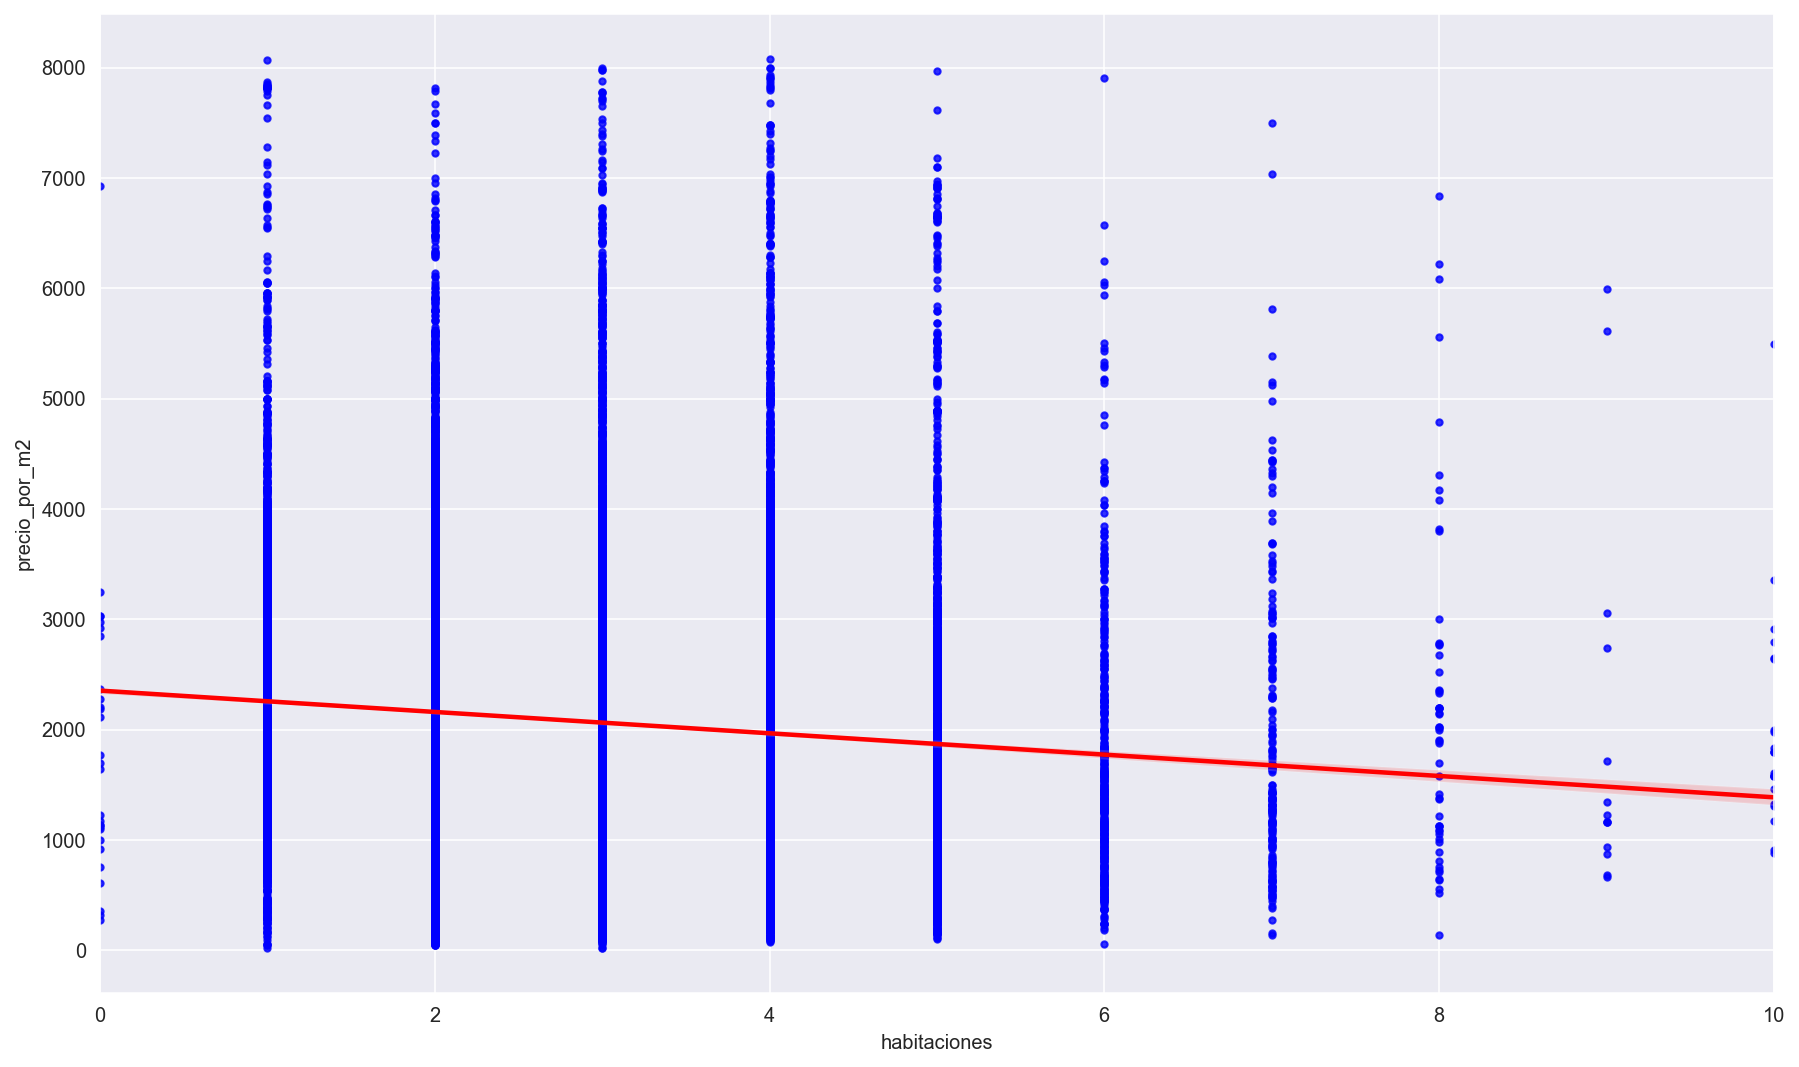

In [24]:
print("*** Habitaciones ***")
X = data[['habitaciones']]
y = data['precio_por_m2']
rls(X, y, 'habitaciones')

#### 3.3.1.3. RLS con normalización (usando *Scale*)

##### Superficie total

*** Superficie total con normalización ***

    Coeficiente	[-0.3899]
    Intercepto	-0.0319
    MAE	0.65
    MSE	0.83
    RMSE	0.91
    R2	0.08
    


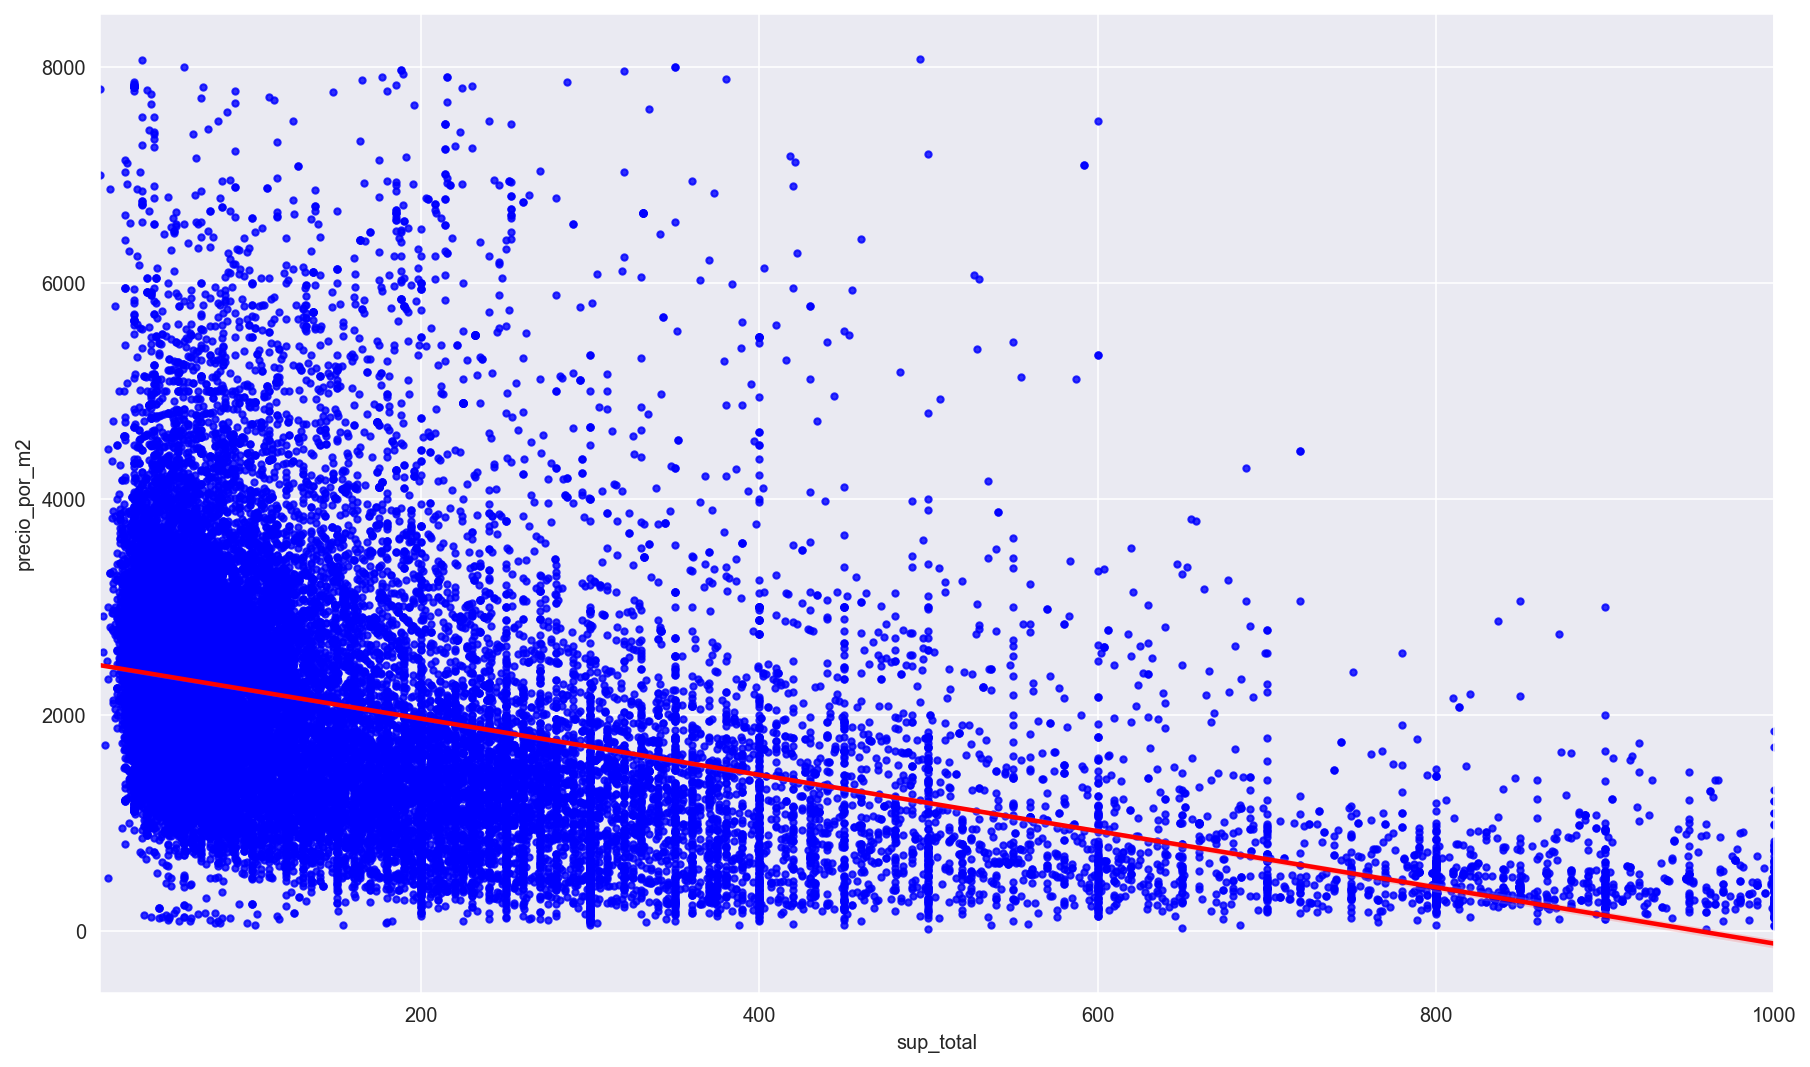

In [25]:
print("*** Superficie total con normalización ***")
Xs = scale(data[["sup_total"]])
ys = scale(data["precio_por_m2"])
rls(Xs, ys, 'sup_total')

##### Superficie cubierta

*** Superficie cubierta con normalización ***

    Coeficiente	[-0.2317]
    Intercepto	-0.047
    MAE	0.67
    MSE	0.9
    RMSE	0.95
    R2	0.01
    


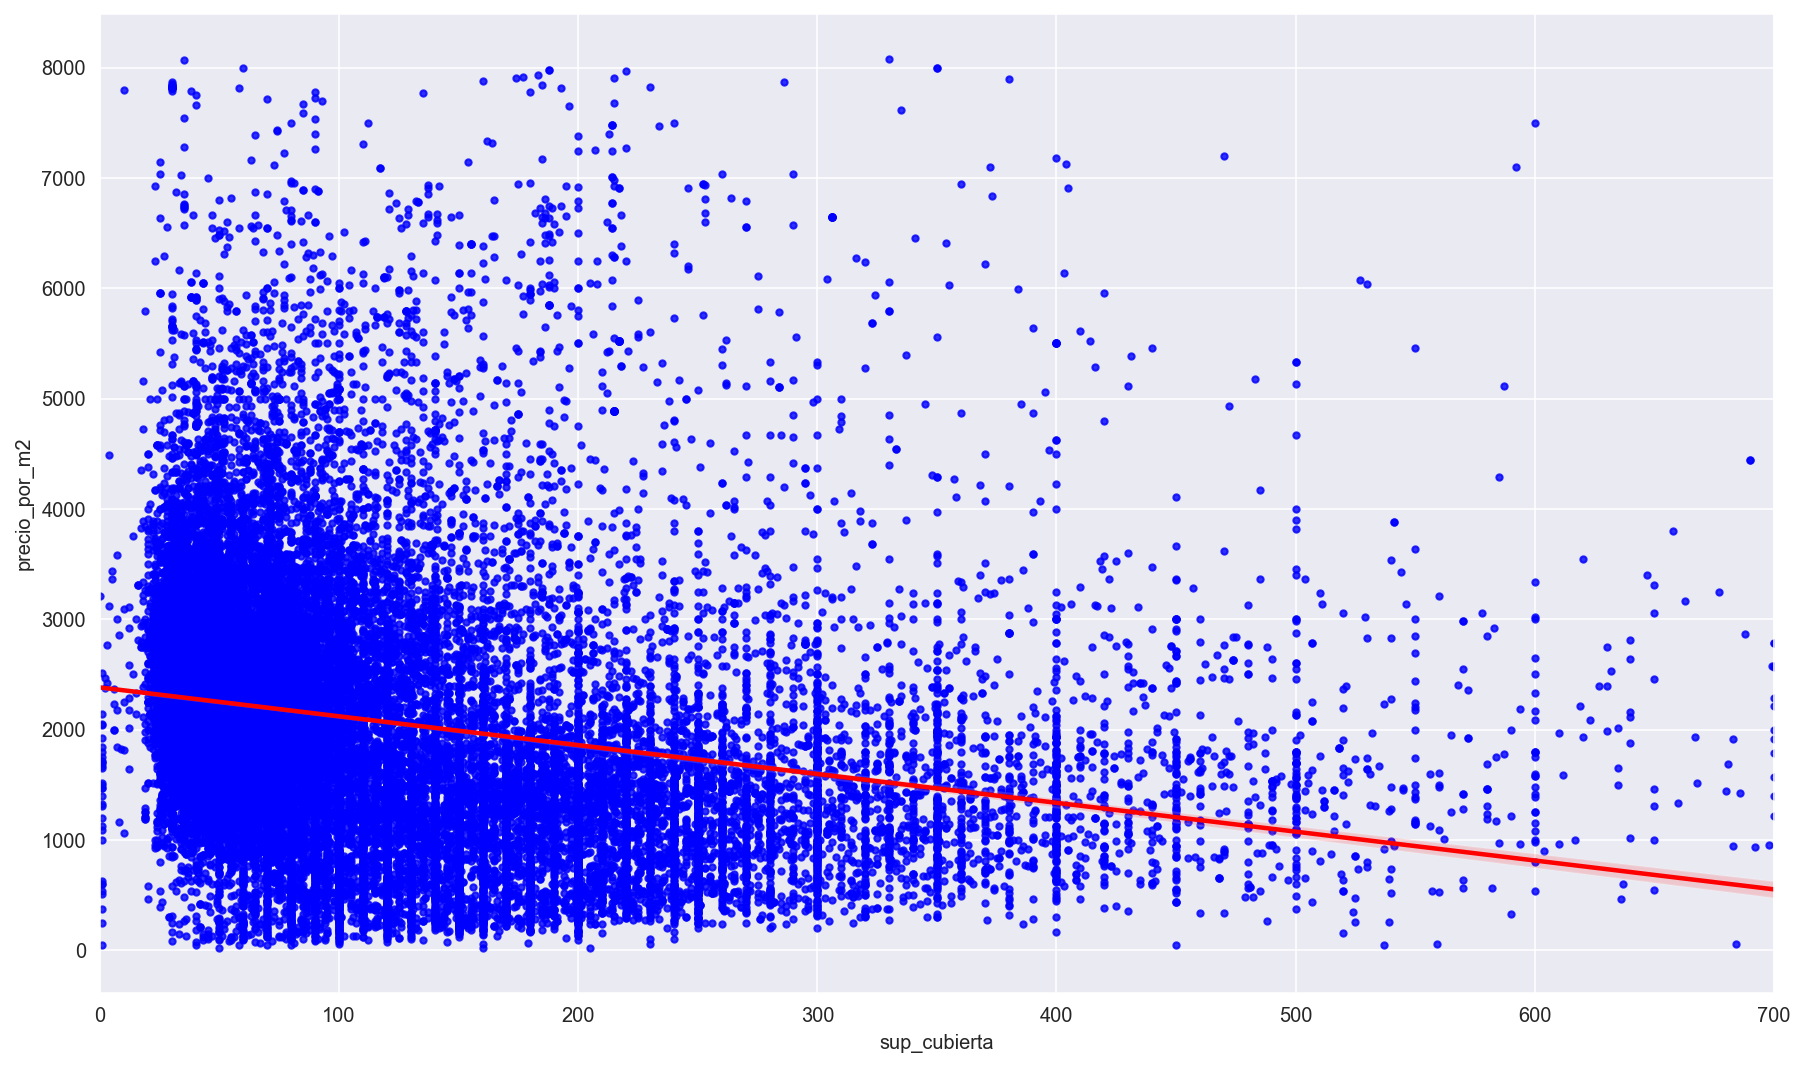

In [26]:
print("*** Superficie cubierta con normalización ***")
Xs = scale(data[["sup_cubierta"]])
ys = scale(data["precio_por_m2"])
rls(Xs, ys, 'sup_cubierta')

##### Habitaciones

*** Habitaciones con normalización ***

    Coeficiente	[-0.123]
    Intercepto	-0.0513
    MAE	0.71
    MSE	0.95
    RMSE	0.98
    R2	-0.05
    


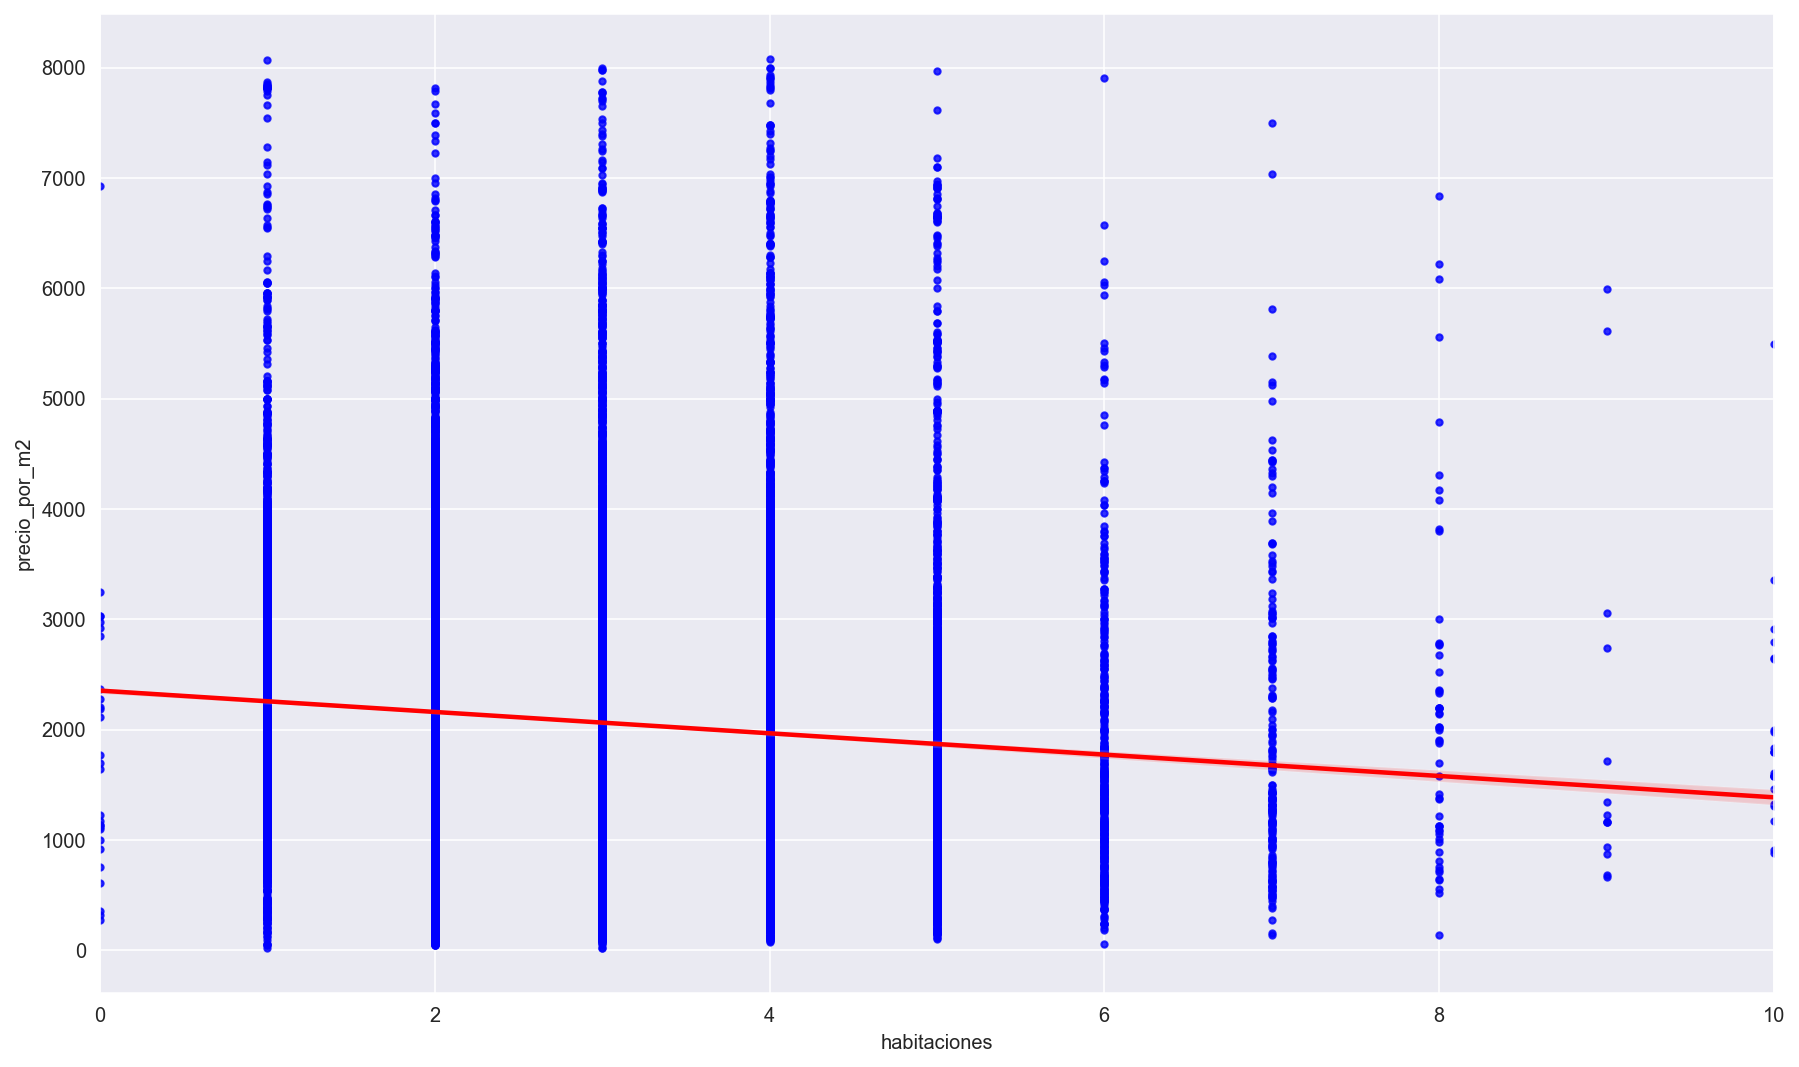

In [27]:
print("*** Habitaciones con normalización ***")
Xs = scale(data[["habitaciones"]])
ys = scale(data["precio_por_m2"])
rls(Xs, ys,'habitaciones')

### *3.3.2. Regresión lineal múltiple (RLM)*

#### 3.3.2.1. Definición de la función regresora *rlm*

In [28]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def rlm(X, y):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=False)
    lr = LinearRegression()
    lr.fit(Xtrain, ytrain)
    ypred = lr.predict(Xtest)
        
    n = len(ytrain)
    p = Xtrain.shape[1]
    R2 = r2_score(ytest, ypred)
    R2_ajustado = 1 - (1 - R2)*((n-1)/(n - p - 1))
    
    print(f'''    
    Intercepto\t{lr.intercept_.round(4)}
    MAE\t\t{mean_absolute_error(ytest, ypred).round(4)}
    MSE\t\t{mean_squared_error(ytest, ypred).round(4)}
    RMSE\t{np.sqrt(mean_squared_error(ytest, ypred)).round(4)}
    R2\t\t{(R2).round(4)}
    R2ADJ\t{(R2_ajustado).round(4)}
    ''')

    plt.plot(y, y, '-.', c='grey')
    plt.scatter(ypred, ytest, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Valores predichos")
    plt.ylabel("Valores reales")
    plt.title('Predicción de precio por m$^2$ utilizando RLM')
    plt.show()

#### 3.3.2.2. RLM de *sup_total*, *sup_cubierta* y *habitaciones*

In [29]:
feature_cols =['sup_total','sup_cubierta','habitaciones']

##### Sin normalización

    
    Intercepto	2383.5634
    MAE		705.1884
    MSE		954164.5861
    RMSE	976.8135
    R2		0.0867
    R2ADJ	0.0866
    


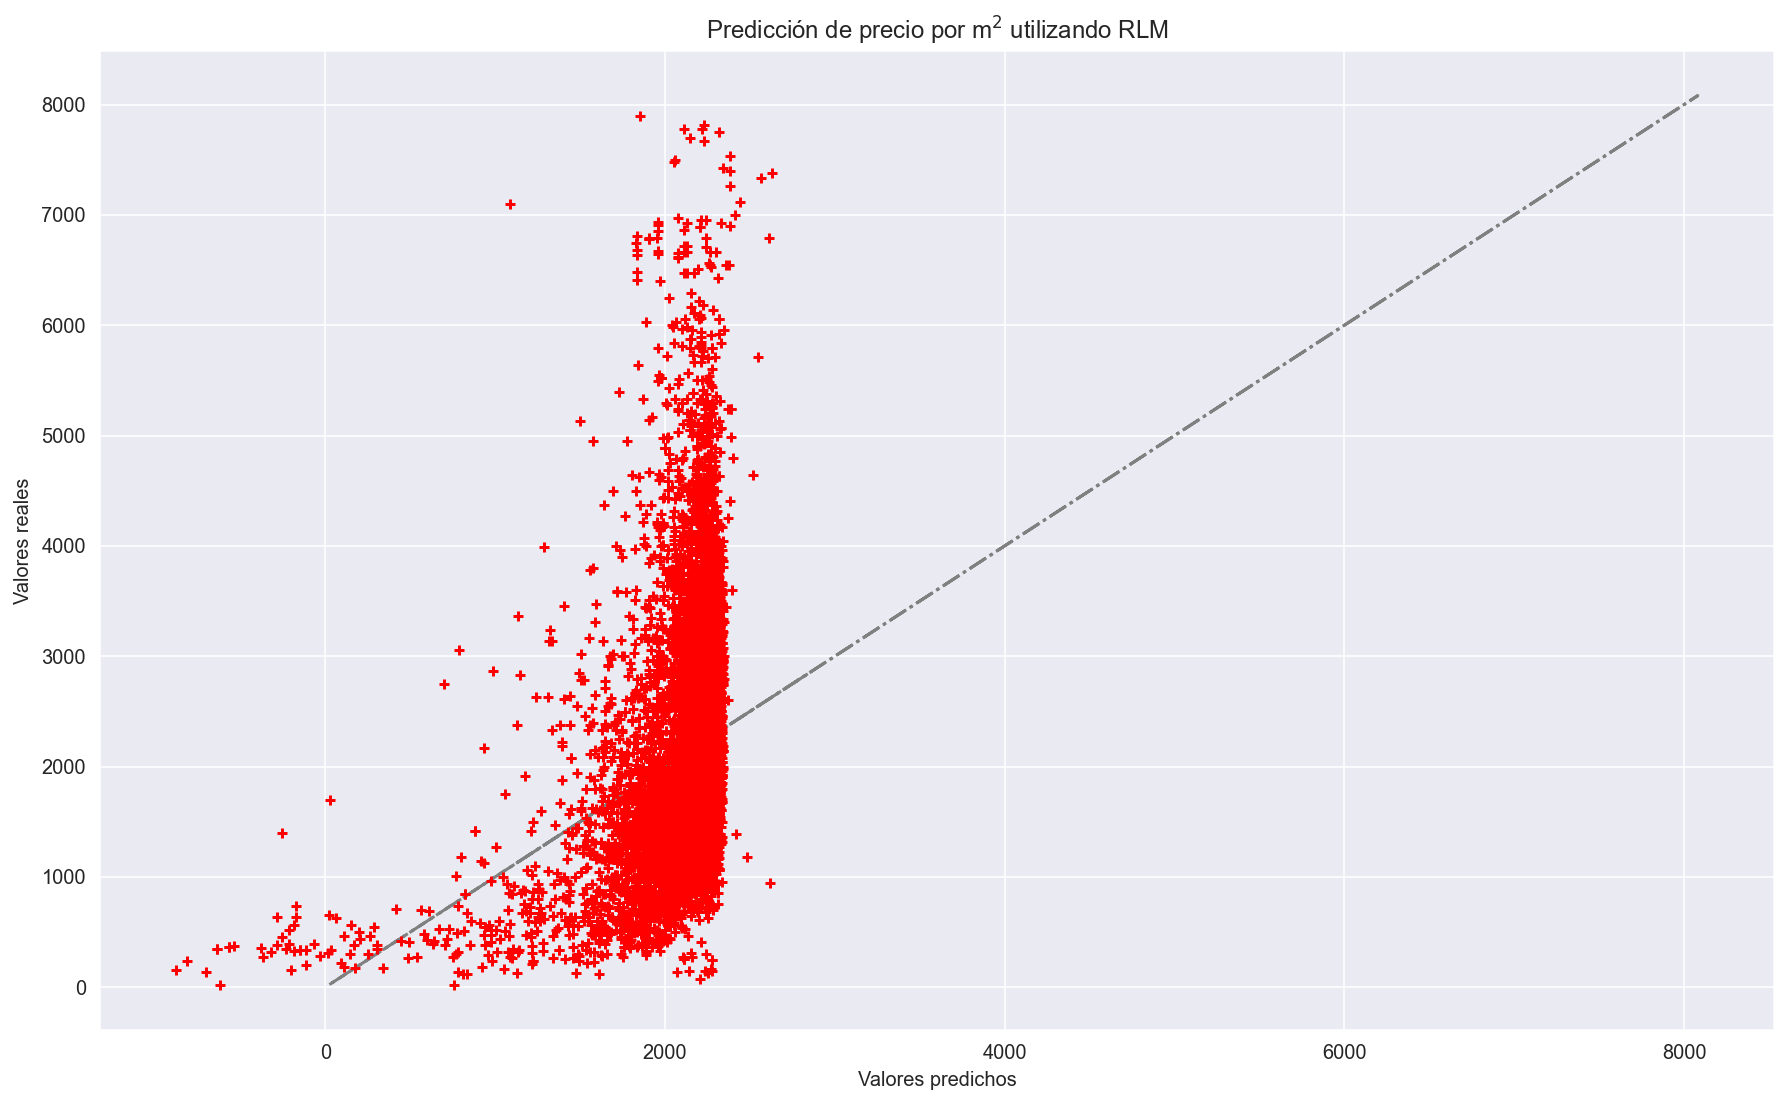

In [30]:
X_orig = data[feature_cols]
y_orig = data["precio_por_m2"]

rlm(X_orig, y_orig)

##### Con normalización (usando *Scale*)

    
    Intercepto	-0.0299
    MAE		0.6567
    MSE		0.8275
    RMSE	0.9097
    R2		0.0867
    R2ADJ	0.0866
    


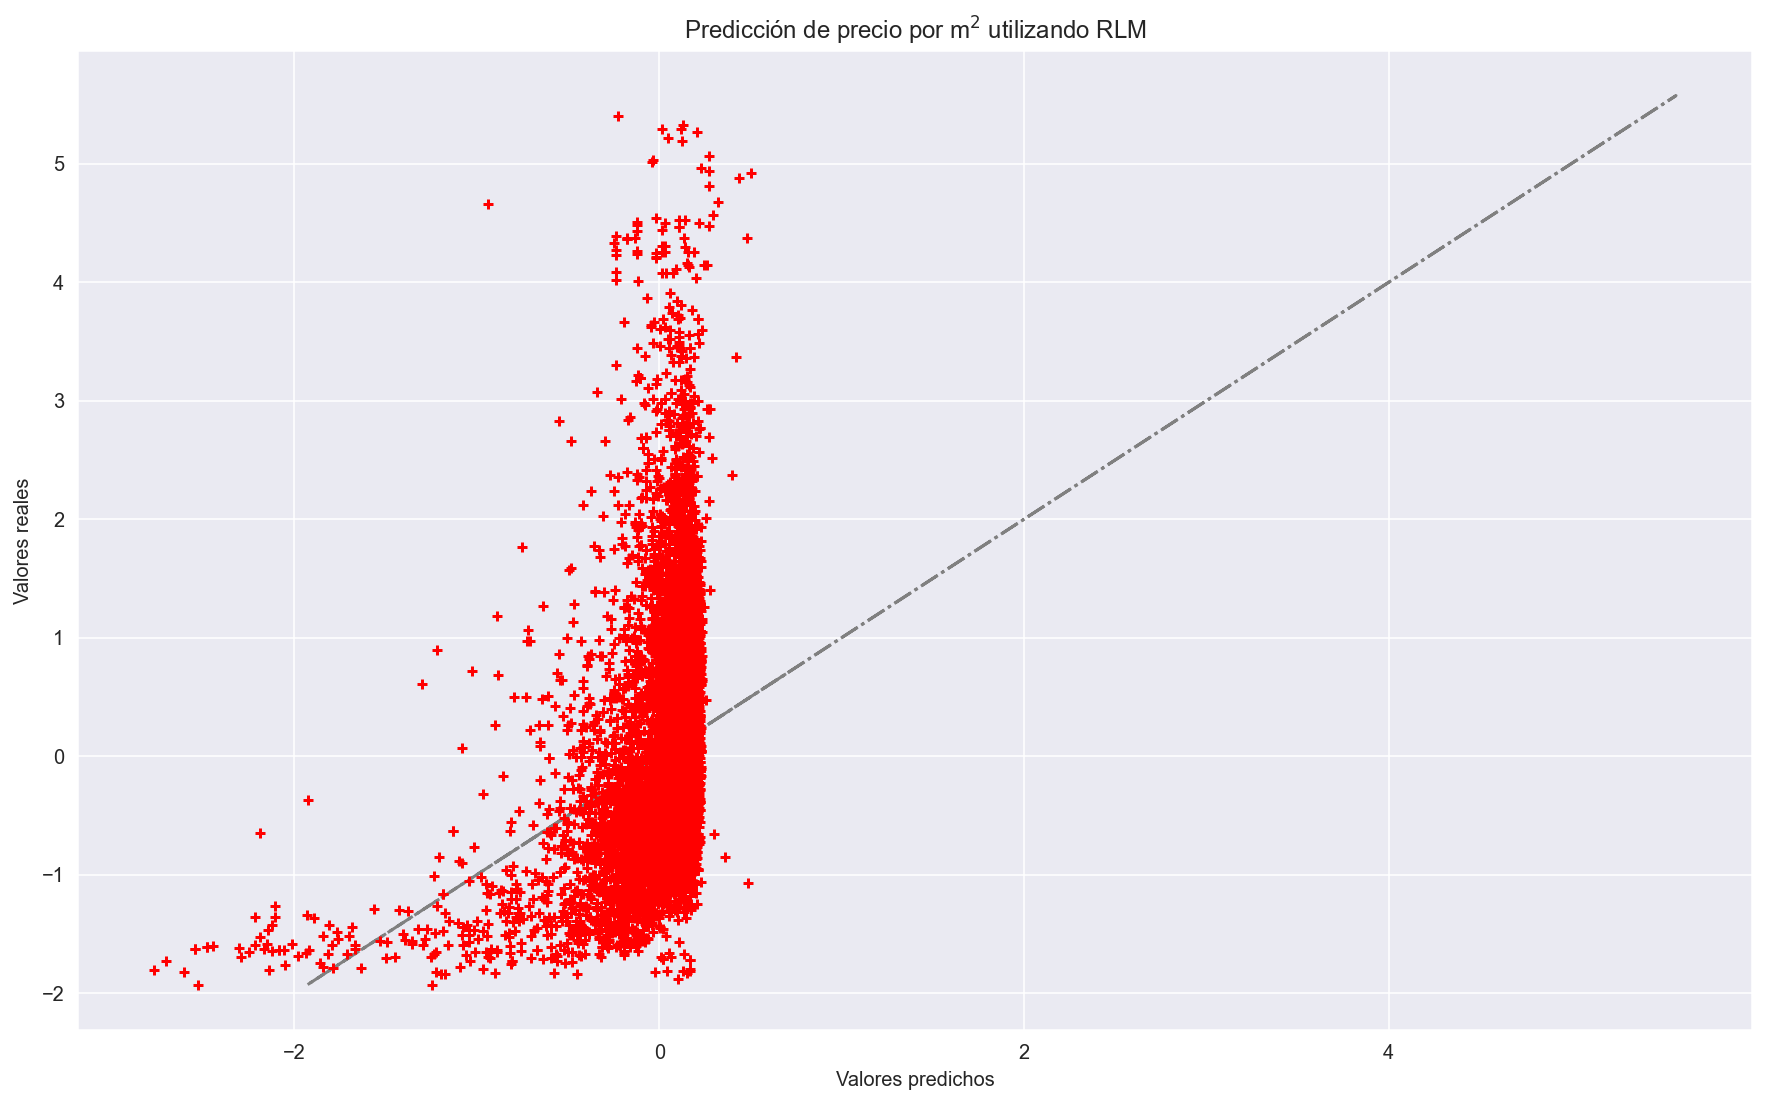

In [31]:
Xs_orig = scale(data[feature_cols])
ys_orig = scale(data["precio_por_m2"])

rlm(Xs_orig, ys_orig)

#### 3.3.2.3. RLM excluyendo *place_name*

In [32]:
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']

##### Sin normalización

    
    Intercepto	1430.748
    MAE		552.7597
    MSE		613603.7786
    RMSE	783.3287
    R2		0.4126
    R2ADJ	0.4122
    


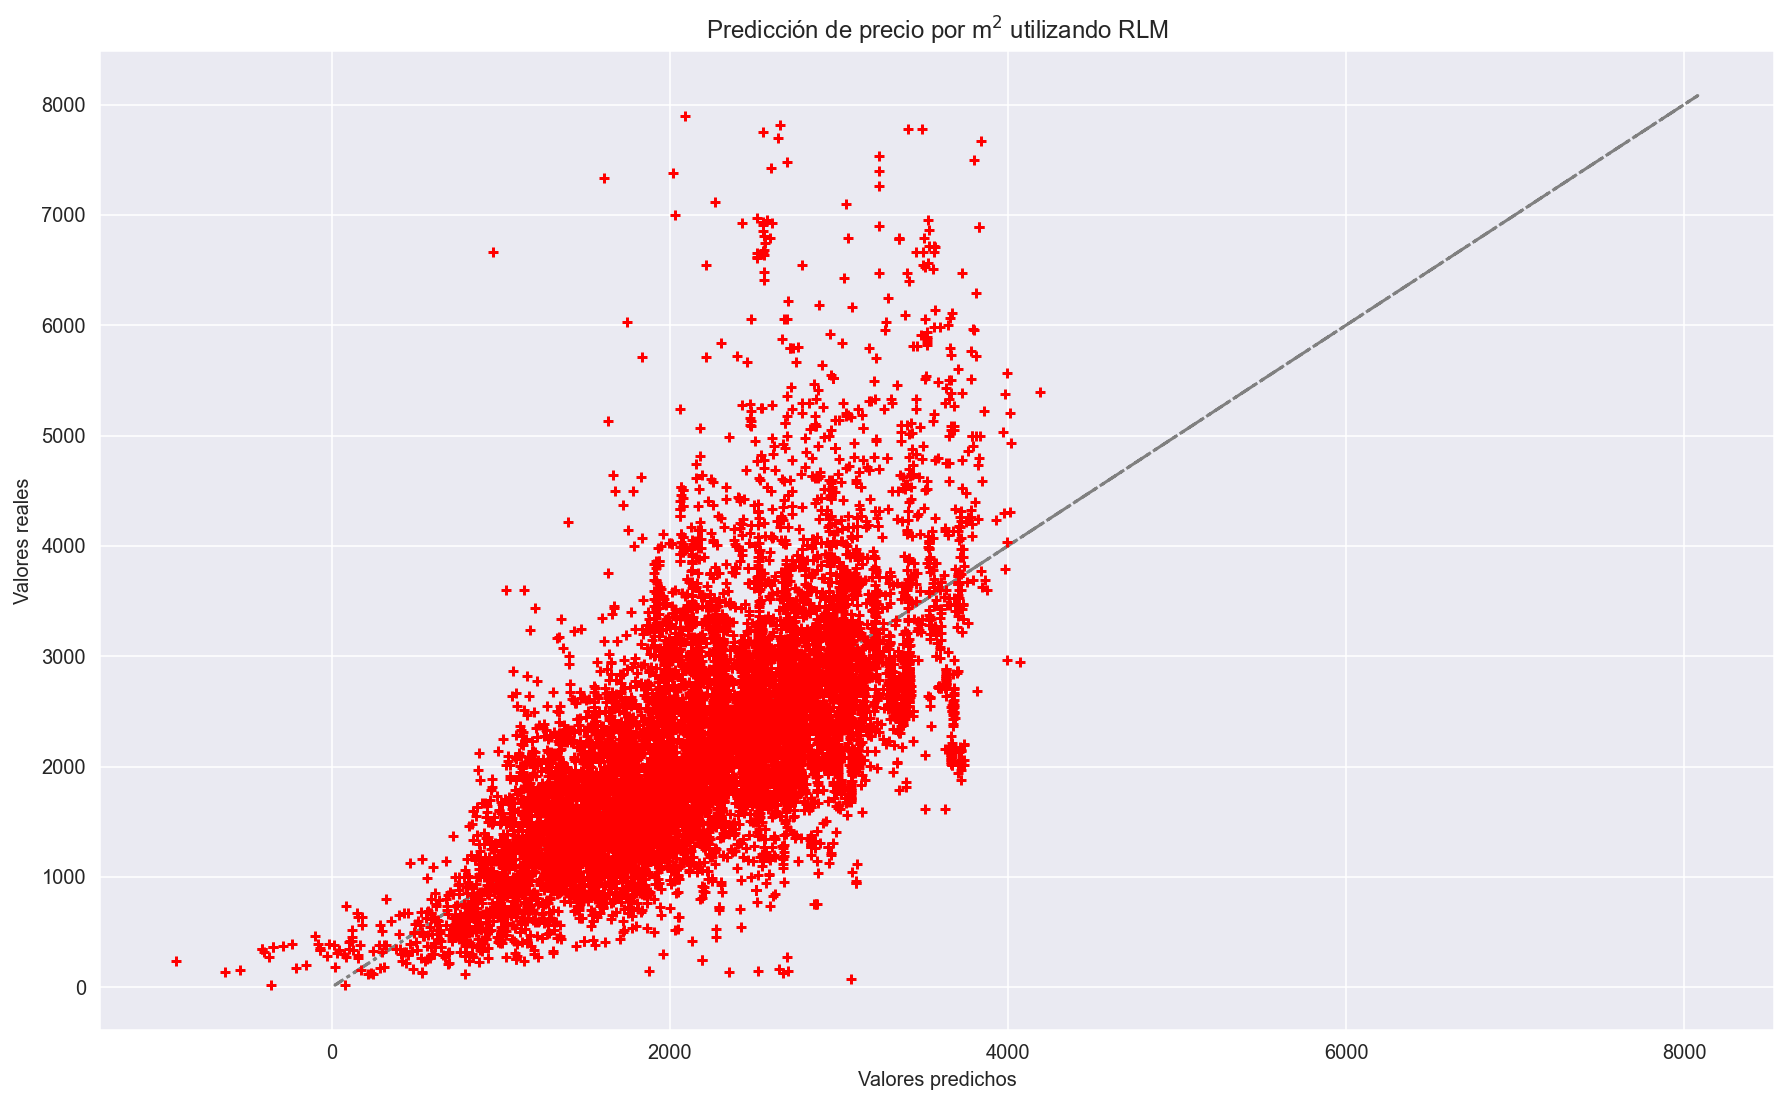

In [33]:
X_todo = data.drop(columns = cols2drop)
y_todo = data['precio_por_m2']
rlm(X_todo, y_todo)

##### Con normalizacion (usando *Scale*)

    
    Intercepto	-0.0075
    MAE		0.5148
    MSE		0.5322
    RMSE	0.7295
    R2		0.4126
    R2ADJ	0.4122
    


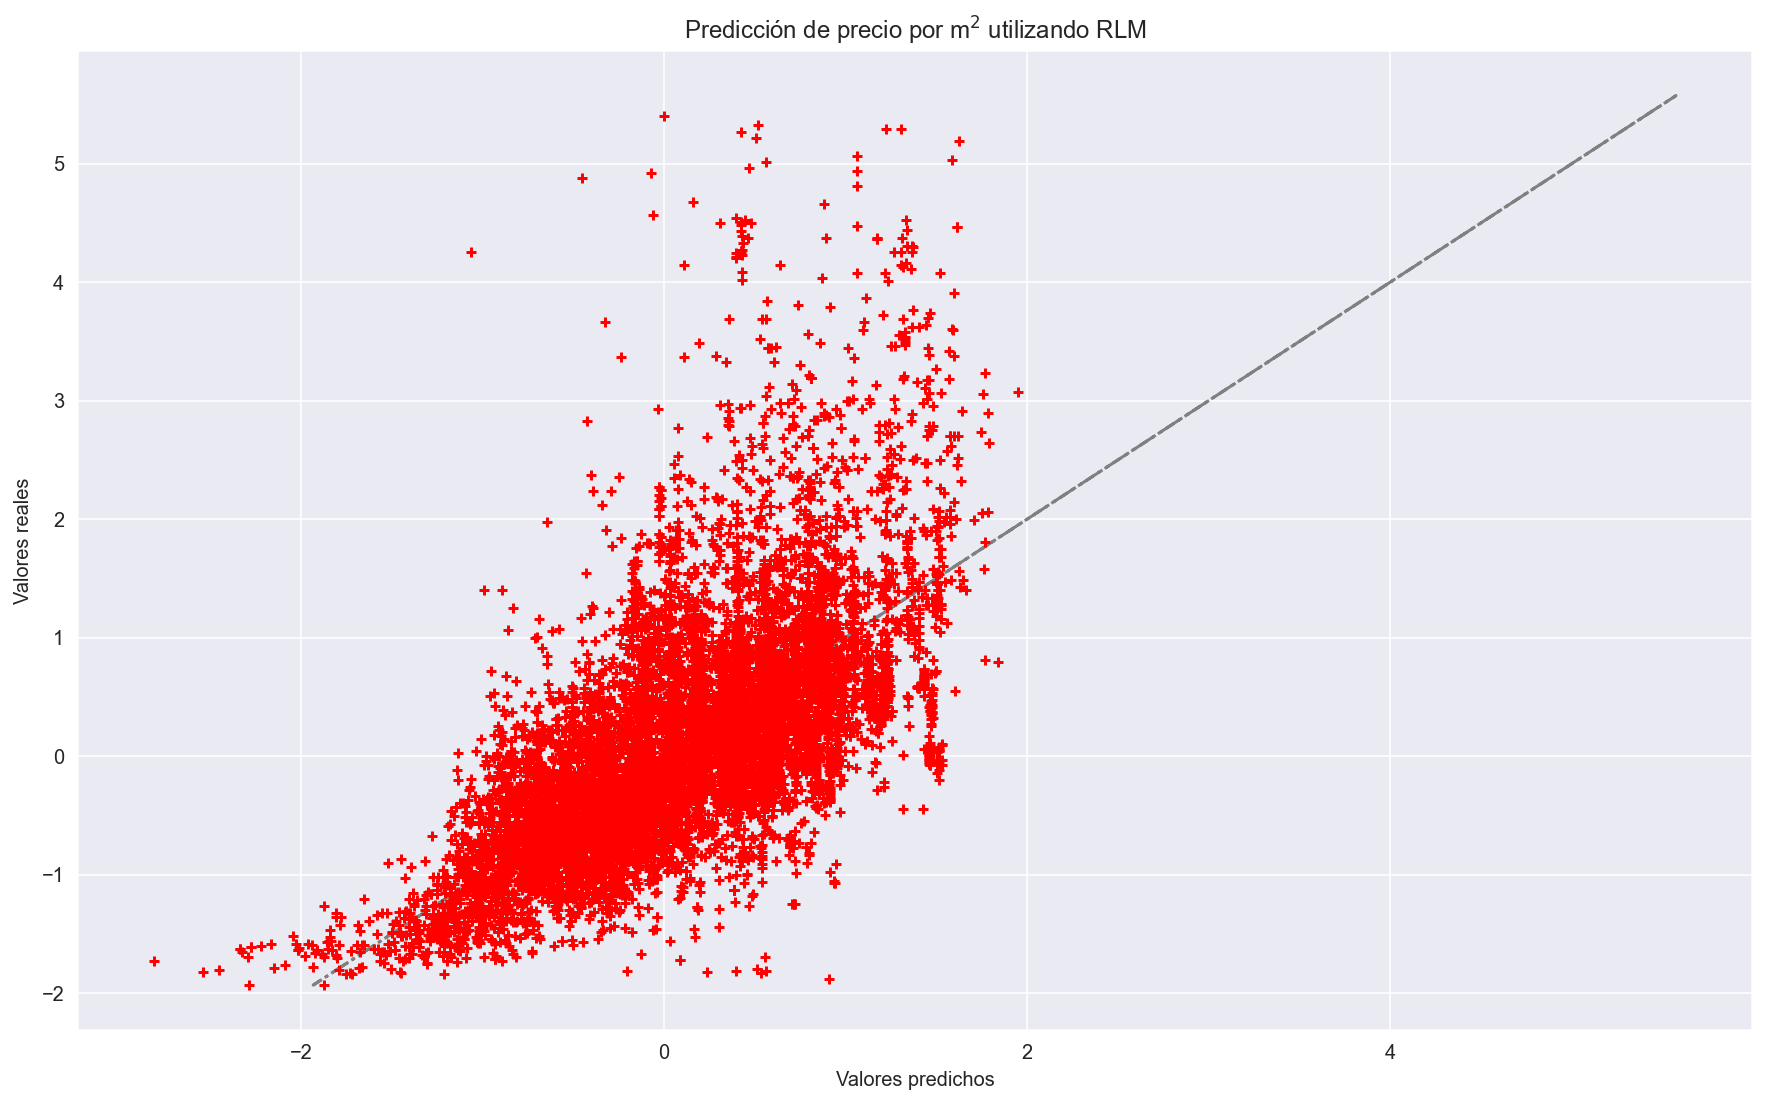

In [34]:
Xs_todo = scale(data.drop(columns = cols2drop))
ys_todo = scale(data['precio_por_m2'])
rlm(Xs_todo, ys_todo)

###  *3.3.3. Regularización*

#### 3.3.3.1. Ridge regression

In [35]:
# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo.
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Ridge
ridge = Ridge(alpha=0.5, normalize=False)
ridge.fit(X_train,y_train)
ypred_ridge = ridge.predict(X_test)

#Modelo Ridge CV
rlmcv = RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 1, 15, 20, 25, 26, 27, 28, 29, 30,31, 32, 33, 34, 35],\
                                        normalize = False, cv = 5,scoring='r2')
rlmcv.fit(X_train, y_train)
ypred_ridgecv = rlmcv.predict(X_test)


print ('R2:', r2_score(y_test, ypred).round(6))
print ("R2_Ridge:", r2_score(y_test, ypred_ridge).round(6))
print ("R2_Ridge_CV:", r2_score(y_test, ypred_ridgecv).round(6))
print ("Best alpha:", rlmcv.alpha_)

Ridge(alpha=0.5)

RidgeCV(alphas=array([1.0e-05, 5.0e-05, 1.0e-04, 5.0e-04, 1.0e-03, 5.0e-03, 1.0e-02,
       5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 1.0e+00, 1.5e+01, 2.0e+01,
       2.5e+01, 2.6e+01, 2.7e+01, 2.8e+01, 2.9e+01, 3.0e+01, 3.1e+01,
       3.2e+01, 3.3e+01, 3.4e+01, 3.5e+01]),
        cv=5, scoring='r2')

R2: 0.481729
R2_Ridge: 0.48173
R2_Ridge_CV: 0.481757
Best alpha: 20.0


#### 3.3.3.2. Lasso regression

In [36]:
from sklearn.linear_model import LassoCV

# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Lasso
lasso = Lasso(alpha=0.5, normalize=False)
lasso.fit(X_train,y_train)
ypred_lasso = lasso.predict(X_test)

#Modelo Lasso CV
lassocv = LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 
lassocv.fit(X_train, y_train)
ypred_lassocv = lassocv.predict(X_test)

print ('R2:', r2_score(y_test, ypred).round(5))
print ("R2_Lasso:", r2_score(y_test, ypred_lasso).round(6))
print ("R2_Lasso_CV:", r2_score(y_test, ypred_lassocv).round(6))
print ("Best alpha:", lassocv.alpha_)

Lasso(alpha=0.5)

LassoCV(alphas=[1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1,
                5, 10],
        cv=5)

R2: 0.48599
R2_Lasso: 0.029623
R2_Lasso_CV: 0.486056
Best alpha: 0.001


#### 3.3.3.3. Elastic Net regression

In [37]:
from sklearn.linear_model import ElasticNetCV

# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo elastic Net
elastic_net = ElasticNet(alpha=0.5, normalize=False)
elastic_net.fit(X_train, y_train)
ypred_elastic = elastic_net.predict(X_test)

#Modelo elastic Net CV
elasticcv = ElasticNetCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 
elasticcv.fit(X_train, y_train)
ypred_elasticcv = elasticcv.predict(X_test)

print ('R2:', r2_score(y_test, ypred).round(6))
print ("R2_Elastic:", r2_score(y_test, ypred_elastic).round(6))
print ("R2_Elastic_CV:", r2_score(y_test, ypred_elasticcv).round(6))
print ("Best alpha:", elasticcv.alpha_)

ElasticNet(alpha=0.5)

ElasticNetCV(alphas=[1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                     0.1, 1, 5, 10],
             cv=5)

R2: 0.490474
R2_Elastic: 0.22572
R2_Elastic_CV: 0.490469
Best alpha: 0.001
